In [1]:
# Step 1: Install necessary packages
!pip install qiskit matplotlib numpy pylatexenc


     ---------------------------------------- 0.0/162.6 kB ? eta -:--:--
     ------------------------------------- 162.6/162.6 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136848 sha256=38b1c70fe7762fec88d5019ad093850d21a36b2bdfb4691fbf786139de983193
  Stored in directory: c:\users\pinku\appdata\local\pip\cache\wheels\b1\7a\33\9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [2]:
!pip install --upgrade qiskit

In [3]:
# Step 2: Import necessary modules
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import matplotlib.pyplot as plt
from qiskit_aer import Aer
import numpy as np
from qiskit.circuit import Gate
from qiskit.circuit.library import RZGate, SXGate, XGate, CXGate
from qiskit.visualization import plot_state_qsphere

In [70]:
%matplotlib inline

In [159]:
# Function to plot the circuit
def plot_circuit(qc, title="Quantum Circuit"):
    """
    Plot the quantum circuit.
    """
    qc.draw('mpl')
    plt.title(title)
    plt.show()

# Function to plot results

def plot_results(results, a, b):
    """
    Plot the results of the quantum addition analysis as a heatmap.
    """
    # Unique noise levels
    p1_values = sorted(set(p1 for (p1, p2) in results.keys()))
    p2_values = sorted(set(p2 for (p1, p2) in results.keys()))

    # Initialize a 2D array to hold the error rates
    error_rates = np.zeros((len(p1_values), len(p2_values)))

    for i, p1 in enumerate(p1_values):
        for j, p2 in enumerate(p2_values):
            if (p1, p2) in results:
                counts = results[(p1, p2)]
                expected_outcome = f"{a + b:04b}"  # Assuming a+b fits in 4 bits
                error = counts.get(expected_outcome, 0)  # Get count for expected outcome
                error_rates[i, j] = 1 - (error / 1000)  # Calculate error rate
            else:
                error_rates[i, j] = np.nan  # If no data, set NaN for plotting

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(error_rates, interpolation='nearest', cmap='Blues', 
               extent=[min(p2_values), max(p2_values), min(p1_values), max(p1_values)],
               aspect='auto', origin='lower')

    plt.colorbar(label='Error Rate')
    plt.xlabel("Noise Probability (p2)")
    plt.ylabel("Noise Probability (p1)")
    plt.title("Quantum Addition Error Rate vs Noise Levels")
    plt.xticks(p2_values)  # Set x-ticks to p2 values
    plt.yticks(p1_values)  # Set y-ticks to p1 values
    plt.savefig('quantum_addition_error_heatmap.png')
    plt.show()

# Function to plot the state vector
def plot_statevector(state_vector, title="State Vector"):
    """
    Plot the state vector using a bar chart.
    """
    # Convert the state vector to a numpy array
    state_vector_np = np.array(state_vector)  # Convert to a NumPy array if needed
    plt.bar(range(len(state_vector_np)), abs(state_vector_np) ** 2)  # Plot the probabilities
    plt.title(title)
    plt.xlabel('Basis States')
    plt.ylabel('Probability Amplitude Squared')
    plt.xticks(range(len(state_vector_np)), [f"|{i}> " for i in range(len(state_vector_np))])
    plt.show()


In [160]:
# Function to tranform the QC to the basis gates

def transform_to_basis(qc: QuantumCircuit) -> QuantumCircuit:
    """
    Transform gates in a Quantum Circuit to {CX, ID, RZ, SX, X}.
    :param qc: Original Quantum Circuit
    :return: Quantum Circuit with only the allowed gate basis
    """
    transformed_qc = QuantumCircuit(*qc.qregs)
    
    for instr in qc.data:
        operation = instr.operation  # Get the operation
        qargs = instr.qubits          # Get the qubits
        
        if operation.name == 'h':
            # Replace Hadamard with RZ and SX (approximate decomposition)
            transformed_qc.rz(np.pi / 2, qargs[0])
            transformed_qc.sx(qargs[0])
            transformed_qc.rz(np.pi / 2, qargs[0])
        elif operation.name == 't':
            # Replace T with an RZ gate
            transformed_qc.rz(np.pi / 4, qargs[0])
        elif operation.name == 'cx':
            transformed_qc.cx(qargs[0], qargs[1])
        else:
            transformed_qc.append(operation, qargs)
    
    return transformed_qc

In [161]:
# Function to perform QFT
def custom_qft(n: int) -> QuantumCircuit:
    """
    Create a Quantum Fourier Transform (QFT) circuit for n qubits.
    :param n: Number of qubits
    :return: Quantum Circuit for QFT
    """
    qft_circuit = QuantumCircuit(n)
    
    for j in range(n):
        qft_circuit.h(j)  # Apply Hadamard gate
        for k in range(j + 1, n):
            qft_circuit.cp(np.pi / (2 ** (k - j)), j, k)  # Apply controlled-phase gate
    
    # Reverse the qubits to match the standard QFT output layout
    for j in range(n // 2):
        qft_circuit.swap(j, n - j - 1)
    
    return qft_circuit

In [162]:
# Function to perform Inverse Qft
def inverse_custom_qft(n: int) -> QuantumCircuit:
    """
    Create the inverse Quantum Fourier Transform (QFT) circuit for n qubits.
    :param n: Number of qubits
    :return: Quantum Circuit for inverse QFT
    """
    inv_qft_circuit = QuantumCircuit(n)
    
    # Reverse the qubits to match the original qubit layout
    for j in range(n // 2):
        inv_qft_circuit.swap(j, n - j - 1)
    
    # Apply the inverse QFT by reversing the QFT steps
    for j in reversed(range(n)):
        for k in range(j + 1, n):
            inv_qft_circuit.cp(-np.pi / (2 ** (k - j)), j, k)  # Apply inverse controlled-phase gate
        inv_qft_circuit.h(j)  # Apply Hadamard gate
    
    return inv_qft_circuit

In [163]:
# Function to create a quantum adder (Draper Adder)
def quantum_adder(a: int, b: int, n: int) -> QuantumCircuit:
  
    """
    Create a Quantum Circuit to add two integers a and b using the Draper adder.
    :param a: First integer
    :param b: Second integer
    :param n: Number of qubits (must fit max(a, b) in binary)
    :return: Quantum Circuit that performs addition
    """

    qc = QuantumCircuit(n)

    # Initialize the qubits with the first number (a)
    for i in range(n):
        if (a >> i) & 1:
            qc.x(i)

    # Apply Custom QFT
    qc.append(custom_qft(n), range(n))

    # Add the second number (b) in Fourier space using phase shifts
    for i in range(n):
        for j in range(i, n):
            if (b >> (j - i)) & 1:
                # Ensure i and j are not the same to avoid duplicate qubit arguments
                if i != j:
                    qc.cp(np.pi / (2 ** (j - i)), i, j)

    # Apply inverse QFT
    qc.append(inverse_custom_qft(n), range(n))
  
    return qc

In [164]:
# Function to Randomize the noise more
def add_random_pauli(qc: QuantumCircuit, qubit: int) -> QuantumCircuit:
    """
    Apply a random Pauli (X, Y, Z) gate to a specific qubit in the circuit.
    
    :param qc: Quantum Circuit to which the Pauli gate will be added
    :param qubit: The qubit index to which the noise will be applied
    :return: Quantum Circuit with the added Pauli noise on the specified qubit
    """
    
    pauli_gate = np.random.choice(['x', 'y', 'z'])
    if pauli_gate == 'x':
        qc.x(qubit)
    elif pauli_gate == 'y':
        qc.y(qubit)
    elif pauli_gate == 'z':
        qc.z(qubit)
    
    return qc

In [165]:
# Function to add noise in the circuit via Pauli gates
def add_pauli_noise(qc: QuantumCircuit, p_single: float, p_double: float) -> QuantumCircuit:
    """
    Add Pauli noise to a quantum circuit.
    
    :param qc: Quantum Circuit where noise will be added
    :param p_single: Probability of adding noise after a single-qubit gate
    :param p_double: Probability of adding noise after a two-qubit gate
    :return: Quantum Circuit with added noise
    """
    
    noisy_qc = QuantumCircuit(*qc.qregs)  # Create a new circuit with the same qubit registers
    for instr in qc.data:
        operation = instr.operation  # Get the operation
        qargs = instr.qubits          # Get the qubits

        # Add the original gate to the new circuit
        noisy_qc.append(operation, qargs)

        # Check if the gate is single or two-qubit and add noise accordingly
        if len(qargs) == 1 and np.random.rand() < p_single:
            noisy_qc = add_random_pauli(noisy_qc, noisy_qc.qubits.index(qargs[0]))
        elif len(qargs) == 2 and np.random.rand() < p_double:
            noisy_qc = add_random_pauli(noisy_qc, noisy_qc.qubits.index(qargs[0]))
            noisy_qc = add_random_pauli(noisy_qc, noisy_qc.qubits.index(qargs[1]))
    
    return noisy_qc

In [169]:
# Step 4: Define the analysis function
def analyze_quantum_addition_with_noise(a, b, noise_levels):
    """
    Analyze the quantum addition circuit under different noise levels.
    """
    results = {}
    n = max(a.bit_length(), b.bit_length()) + 1  # Number of qubits needed
    print(f"Quantum Adder")
    print(quantum_adder(a,b,n).draw())
    print(f"Quantum Adder After basis tranform")
    print("\n")
    print(transform_to_basis(quantum_adder(a,b,n)).draw())
    print("\n")
    
    for p1, p2 in noise_levels:
        # Create the quantum adder circuit
        qc = quantum_adder(a, b, n)
        
        # Convert the circuit to the basis gates
        transformed_qc = transform_to_basis(qc)  # Transform the circuit to the basis gates
        
        # Add noise to the circuit
        noisy_qc = add_pauli_noise(transformed_qc, p_single=p1, p_double=p2)
        
        print(f"Quantum Adder Circuit with Noise p1={p1}, p2={p2}")
        print(noisy_qc.draw())
        
        # Simulate and get state vector
        simulator = Aer.get_backend('statevector_simulator')  # Use statevector simulator
        compiled_circuit = transpile(noisy_qc, simulator)  # Compile the circuit for the simulator
        state_job = simulator.run(compiled_circuit)  # Execute the compiled circuit
        state_vector = state_job.result().get_statevector()  # Retrieve state vector
        
        
        # Plot the state vector using your custom visualization
        plot_statevector(state_vector, title=f"State Vector with Noise p1={p1}, p2={p2}")
        
        # Measure the noisy circuit
        noisy_qc.measure_all()
        compiled_measurement_circuit = transpile(noisy_qc, simulator)  # Compile measurement circuit
        job = simulator.run(compiled_measurement_circuit, shots=1000)  # Execute measurement
        result = job.result()
        counts = result.get_counts()
        
        # Store results for analysis
        results[(p1, p2)] = counts
        
         # Print and visualize the counts
        print(f"\nResults for noise levels p1={p1}, p2={p2}:")
        for outcome, count in counts.items():
            print(f"Outcome {outcome}: {count} times")
            
    return results

Quantum Adder
     ┌───┐┌───────────────┐                  ┌───────────────┐
q_0: ┤ X ├┤0              ├─■────────────────┤0              ├
     ├───┤│               │ │                │               │
q_1: ┤ X ├┤1              ├─┼────────■───────┤1              ├
     └───┘│  circuit-2651 │ │P(π/4)  │       │  circuit-2654 │
q_2: ─────┤2              ├─■────────┼───────┤2              ├
          │               │          │P(π/4) │               │
q_3: ─────┤3              ├──────────■───────┤3              ├
          └───────────────┘                  └───────────────┘
Quantum Adder After basis tranform


     ┌───┐┌───────────────┐                  ┌───────────────┐
q_0: ┤ X ├┤0              ├─■────────────────┤0              ├
     ├───┤│               │ │                │               │
q_1: ┤ X ├┤1              ├─┼────────■───────┤1              ├
     └───┘│  circuit-2658 │ │P(π/4)  │       │  circuit-2661 │
q_2: ─────┤2              ├─■────────┼───────┤2              ├
    

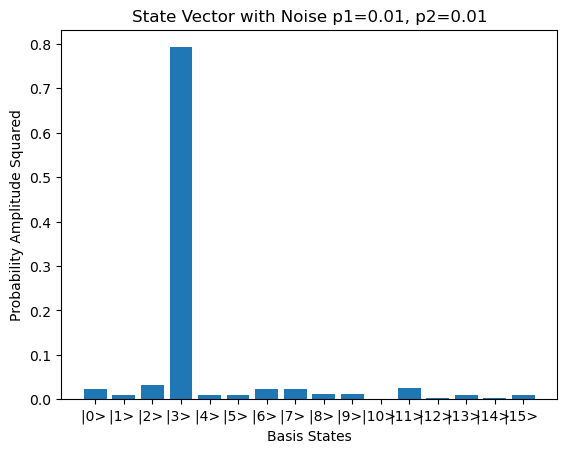


Results for noise levels p1=0.01, p2=0.01:
Outcome 0011: 810 times
Outcome 1101: 8 times
Outcome 0010: 27 times
Outcome 1011: 19 times
Outcome 0001: 11 times
Outcome 1111: 7 times
Outcome 0111: 15 times
Outcome 0000: 29 times
Outcome 0100: 8 times
Outcome 0110: 21 times
Outcome 0101: 17 times
Outcome 1001: 14 times
Outcome 1100: 2 times
Outcome 1110: 1 times
Outcome 1000: 11 times
Quantum Adder Circuit with Noise p1=0.05, p2=0.01
     ┌───┐┌───────────────┐                  ┌───────────────┐
q_0: ┤ X ├┤0              ├─■────────────────┤0              ├
     ├───┤│               │ │                │               │
q_1: ┤ X ├┤1              ├─┼────────■───────┤1              ├
     └───┘│  circuit-2677 │ │P(π/4)  │       │  circuit-2680 │
q_2: ─────┤2              ├─■────────┼───────┤2              ├
          │               │          │P(π/4) │               │
q_3: ─────┤3              ├──────────■───────┤3              ├
          └───────────────┘                  └───────────────

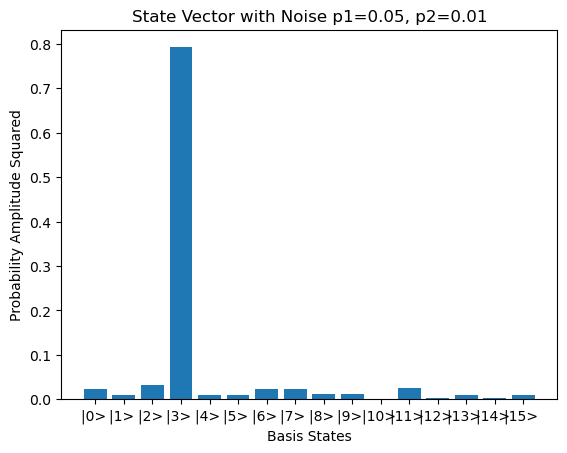


Results for noise levels p1=0.05, p2=0.01:
Outcome 0011: 802 times
Outcome 0010: 35 times
Outcome 0001: 11 times
Outcome 1111: 10 times
Outcome 0110: 24 times
Outcome 0000: 23 times
Outcome 0111: 21 times
Outcome 0100: 10 times
Outcome 1000: 14 times
Outcome 1101: 9 times
Outcome 1011: 24 times
Outcome 1001: 10 times
Outcome 1100: 2 times
Outcome 0101: 4 times
Outcome 1110: 1 times
Quantum Adder Circuit with Noise p1=0.1, p2=0.01
     ┌───┐┌───────────────┐                  ┌───────────────┐
q_0: ┤ X ├┤0              ├─■────────────────┤0              ├
     ├───┤│               │ │                │               │
q_1: ┤ X ├┤1              ├─┼────────■───────┤1              ├
     └───┘│  circuit-2688 │ │P(π/4)  │       │  circuit-2691 │
q_2: ─────┤2              ├─■────────┼───────┤2              ├
          │               │          │P(π/4) │               │
q_3: ─────┤3              ├──────────■───────┤3              ├
          └───────────────┘                  └───────────────

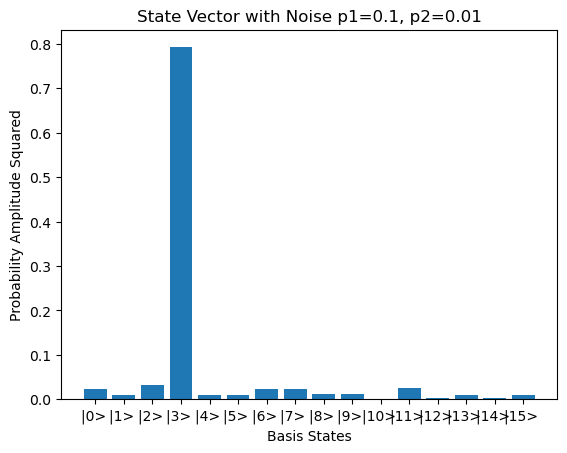


Results for noise levels p1=0.1, p2=0.01:
Outcome 0011: 791 times
Outcome 0010: 34 times
Outcome 1011: 26 times
Outcome 0000: 37 times
Outcome 0111: 20 times
Outcome 1111: 14 times
Outcome 0101: 8 times
Outcome 0100: 13 times
Outcome 0110: 19 times
Outcome 1000: 10 times
Outcome 1001: 13 times
Outcome 1101: 4 times
Outcome 0001: 3 times
Outcome 1110: 4 times
Outcome 1100: 3 times
Outcome 1010: 1 times
Quantum Adder Circuit with Noise p1=0.01, p2=0.05
     ┌───┐┌───────────────┐                  ┌───────────────┐
q_0: ┤ X ├┤0              ├─■────────────────┤0              ├
     ├───┤│               │ │                │               │
q_1: ┤ X ├┤1              ├─┼────────■───────┤1              ├
     └───┘│  circuit-2699 │ │P(π/4)  │       │  circuit-2702 │
q_2: ─────┤2              ├─■────────┼───────┤2              ├
          │               │          │P(π/4) │               │
q_3: ─────┤3              ├──────────■───────┤3              ├
          └───────────────┘             

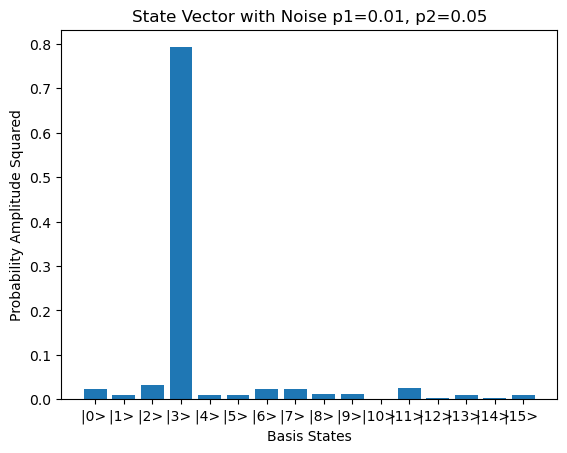


Results for noise levels p1=0.01, p2=0.05:
Outcome 0011: 809 times
Outcome 0010: 24 times
Outcome 1011: 20 times
Outcome 0110: 17 times
Outcome 1111: 15 times
Outcome 0111: 21 times
Outcome 0000: 30 times
Outcome 1001: 14 times
Outcome 1101: 10 times
Outcome 0101: 12 times
Outcome 1100: 1 times
Outcome 1000: 9 times
Outcome 0001: 10 times
Outcome 1110: 2 times
Outcome 0100: 5 times
Outcome 1010: 1 times
Quantum Adder Circuit with Noise p1=0.05, p2=0.05
     ┌───┐┌───────────────┐                  ┌───────────────┐
q_0: ┤ X ├┤0              ├─■────────────────┤0              ├
     ├───┤│               │ │                │               │
q_1: ┤ X ├┤1              ├─┼────────■───────┤1              ├
     └───┘│  circuit-2710 │ │P(π/4)  │       │  circuit-2713 │
q_2: ─────┤2              ├─■────────┼───────┤2              ├
          │               │          │P(π/4) │               │
q_3: ─────┤3              ├──────────■───────┤3              ├
          └───────────────┘           

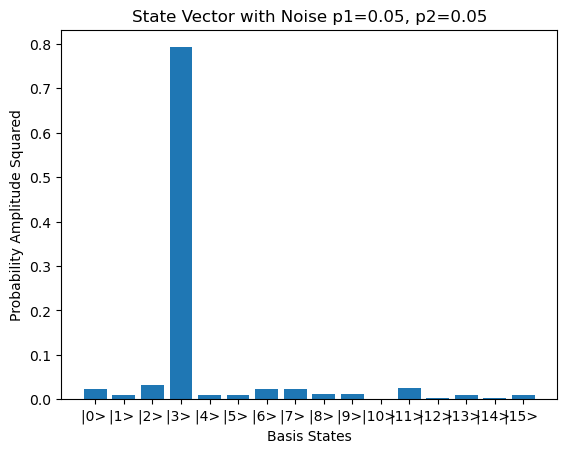


Results for noise levels p1=0.05, p2=0.05:
Outcome 1100: 4 times
Outcome 0011: 800 times
Outcome 1001: 12 times
Outcome 0010: 28 times
Outcome 0101: 7 times
Outcome 0111: 23 times
Outcome 0000: 26 times
Outcome 0110: 32 times
Outcome 1011: 15 times
Outcome 1101: 10 times
Outcome 0100: 9 times
Outcome 0001: 10 times
Outcome 1111: 11 times
Outcome 1000: 11 times
Outcome 1010: 1 times
Outcome 1110: 1 times
Quantum Adder Circuit with Noise p1=0.1, p2=0.1
     ┌───┐┌───────────────┐                  ┌───────────────┐
q_0: ┤ X ├┤0              ├─■────────────────┤0              ├
     ├───┤│               │ │                │               │
q_1: ┤ X ├┤1              ├─┼────────■───────┤1              ├
     └───┘│  circuit-2721 │ │P(π/4)  │       │  circuit-2724 │
q_2: ─────┤2              ├─■────────┼───────┤2              ├
          │               │          │P(π/4) │               │
q_3: ─────┤3              ├──────────■───────┤3              ├
          └───────────────┘             

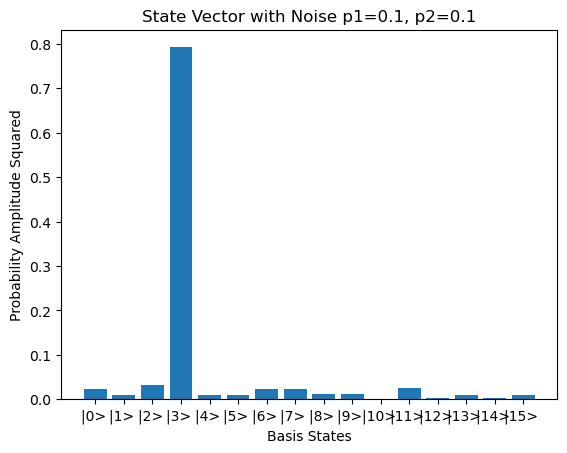


Results for noise levels p1=0.1, p2=0.1:
Outcome 0011: 789 times
Outcome 1001: 10 times
Outcome 0001: 16 times
Outcome 0000: 24 times
Outcome 0010: 31 times
Outcome 1011: 30 times
Outcome 1111: 11 times
Outcome 0111: 29 times
Outcome 1000: 13 times
Outcome 0110: 22 times
Outcome 1010: 2 times
Outcome 0101: 3 times
Outcome 0100: 8 times
Outcome 1101: 8 times
Outcome 1110: 2 times
Outcome 1100: 2 times


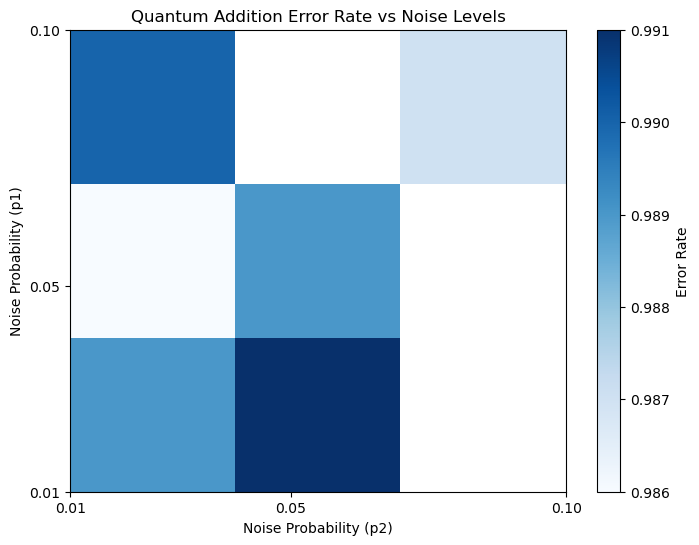

In [170]:
# Step 5: Run the analysis with specified noise levels
if __name__ == "__main__":
    noise_levels = [(0.01, 0.01), (0.05, 0.01), (0.1, 0.01), (0.01, 0.05), (0.05, 0.05), (0.1, 0.1)]  # Define noise levels
    results = analyze_quantum_addition_with_noise(3, 5, noise_levels)  # Example: Adding 3 and 5

    # Visualize the results
    plot_results(results,3,5)